In [1]:
# Cell 1: Install Dependencies
# Run this cell once per session to install the necessary packages.
# Ensure the CuPy version matches your CUDA Toolkit installation.
# For CUDA 11.x, use 'cupy-cuda11x'. For CUDA 12.x, use 'cupy-cuda12x'.

!pip install numpy matplotlib scipy cupy-cuda12x

In [2]:
# Cell 2: Imports and GPU Initialization

import numpy as np
import time
from scipy.stats import norm
import matplotlib.pyplot as plt

# --- GPU Setup ---
# This block checks for a CUDA-enabled GPU and initializes CuPy.
# It sets a global flag and prints the device name for verification.
try:
    import cupy as cp
    device = cp.cuda.Device(0)
    device.use()
    GPU_ENABLED = True
    # Decode the byte string from getDeviceProperties for clean printing
    gpu_name = cp.cuda.runtime.getDeviceProperties(0)['name'].decode('utf-8')
    print(f"✅ CuPy found. GPU backend enabled on: {gpu_name}")
except ImportError as e:
    cp = np # Fallback to NumPy if CuPy is not found
    GPU_ENABLED = False
    print(f"⚠️ CuPy import failed with error: {e}. Running on CPU (NumPy) only.")
except Exception as e:
    cp = np
    GPU_ENABLED = False
    print(f"⚠️ An error occurred during GPU initialization: {e}. Running on CPU (NumPy) only.")

✅ CuPy found. GPU backend enabled on: NVIDIA RTX A6000


In [3]:
# Cell 3: Financial Product Definition (EuropeanOption Class)

class EuropeanOption:
    """
    A class to encapsulate the parameters of a European-style option.

    This structure separates the financial product from the numerical method,
    allowing us to later plug this option into different pricers (e.g., Heston, MLMC).
    """
    def __init__(self, S0: float, K: float, T: float, r: float, sigma: float, option_type: str):
        """
        Initializes the option parameters.

        Args:
            S0 (float): Initial stock price.
            K (float): Strike price.
            T (float): Time to maturity (in years).
            r (float): Risk-free interest rate (annual).
            sigma (float): Volatility of the underlying asset (annual).
            option_type (str): 'call' or 'put'.
        """
        if option_type.lower() not in ['call', 'put']:
            raise ValueError("option_type must be 'call' or 'put'.")
        self.S0 = S0
        self.K = K
        self.T = T
        self.r = r
        self.sigma = sigma
        self.option_type = option_type.lower()

    def payoff(self, S_T):
        """
        Calculates the option payoff at maturity.
        This function is designed to work with both NumPy and CuPy vectors.
        """
        # cp.get_array_module(S_T) automatically returns `numpy` or `cupy`
        # depending on the type of the input array S_T. This is a key
        # pattern for writing backend-agnostic code.
        xp = cp.get_array_module(S_T)
        
        if self.option_type == 'call':
            return xp.maximum(S_T - self.K, 0)
        else: # put
            return xp.maximum(self.K - S_T, 0)

    def analytical_price(self) -> float:
        """
        Calculates the exact price using the Black-Scholes formula.
        This is crucial for validating our Monte Carlo results.
        """
        d1 = (np.log(self.S0 / self.K) + (self.r + 0.5 * self.sigma**2) * self.T) / (self.sigma * np.sqrt(self.T))
        d2 = d1 - self.sigma * np.sqrt(self.T)

        if self.option_type == 'call':
            price = self.S0 * norm.cdf(d1) - self.K * np.exp(-self.r * self.T) * norm.cdf(d2)
        else: # put
            price = self.K * np.exp(-self.r * self.T) * norm.cdf(-d2) - self.S0 * norm.cdf(-d1)
        
        return price

print("EuropeanOption class defined.")

EuropeanOption class defined.


In [4]:
# Cell 4: The Monte Carlo Pricing Engine Class

class MonteCarloPricer:
    """
    A Monte Carlo pricer that can use different computational backends (CPU/GPU).
    """
    def __init__(self, option: EuropeanOption, num_paths: int, num_steps: int, backend: str = 'cpu'):
        """Initializes the pricer."""
        self.option = option
        self.num_paths = int(num_paths)
        self.num_steps = int(num_steps)

        if backend.lower() == 'gpu' and not GPU_ENABLED:
            print("⚠️ Warning: GPU backend requested but not available. Falling back to CPU.")
            self.backend = 'cpu'
        else:
            self.backend = backend.lower()

        # The _xp attribute will hold either the numpy or cupy module.
        # All numerical operations will use self._xp to remain backend-agnostic.
        self._xp = cp if self.backend == 'gpu' else np
        
        self.device = "GPU" if self.backend == 'gpu' else "CPU"
        print(f"Pricer initialized on {self.device} with {self.num_paths:,} paths.")

    def _generate_paths_gbm(self):
        """
        Generates asset price paths using Geometric Brownian Motion.
        The entire computation is done on the selected device (CPU or GPU).
        S_t = S_{t-1} * exp((r - 0.5 * sigma^2) * dt + sigma * sqrt(dt) * Z)
        """
        xp = self._xp
        opt = self.option
        dt = opt.T / self.num_steps
        
        # Generate all random numbers at once for maximum efficiency.
        Z = xp.random.standard_normal((self.num_steps, self.num_paths))
        
        drift = (opt.r - 0.5 * opt.sigma**2) * dt
        diffusion = opt.sigma * xp.sqrt(dt)
        
        # We simulate step-by-step to be extendable to path-dependent options.
        # S_t starts as an array of S0 for all paths.
        S_t = xp.full(self.num_paths, opt.S0, dtype=xp.float64)
        
        for i in range(self.num_steps):
            S_t *= xp.exp(drift + diffusion * Z[i, :])
            
        # For a European option, we only need the final price.
        return S_t

    def price(self) -> (float, float):
        """
        Executes the Monte Carlo simulation to price the option.
        Returns the estimated price and the standard error of the estimate.
        """
        start_time = time.time()
        
        # 1. Generate terminal prices on the chosen device
        S_T = self._generate_paths_gbm()
        
        # 2. Calculate payoffs on the chosen device
        payoffs = self.option.payoff(S_T)
        
        # 3. Discount payoffs and find the mean price
        discounted_payoffs = payoffs * self._xp.exp(-self.option.r * self.option.T)
        price = self._xp.mean(discounted_payoffs)
        
        # 4. Calculate standard error for confidence
        std_error = self._xp.std(discounted_payoffs) / self._xp.sqrt(self.num_paths)
        
        # If running on GPU, move results back to CPU (host) memory for printing/further use
        if self.backend == 'gpu':
            price = cp.asnumpy(price)
            std_error = cp.asnumpy(std_error)
            # This ensures all GPU computations are finished before stopping the timer
            cp.cuda.Stream.null.synchronize() 
            
        end_time = time.time()
        self.execution_time = end_time - start_time
        
        return float(price), float(std_error)

print("MonteCarloPricer class defined.")

MonteCarloPricer class defined.


In [5]:
# Cell 5: Main Execution and Benchmarking

# --- 1. Define Common Parameters ---
option_params = {
    'S0': 100.0,
    'K': 105.0,
    'T': 1.0,
    'r': 0.05,
    'sigma': 0.2,
    'option_type': 'call'
}

# Use a large number of paths to make the GPU speedup obvious
simulation_params = {
    'num_paths': 10_000_000, # 10 million paths
    'num_steps': 252       # Corresponds to daily steps for one year
}

print("=========================================================")
print("  Monte Carlo Option Pricing with CUDA Acceleration")
print("=========================================================\n")

# --- 2. Create the Option object and Validate with Analytical Formula ---
european_call = EuropeanOption(**option_params)
analytical_price = european_call.analytical_price()
print(f"--- Option Parameters ---")
for key, val in option_params.items():
    print(f"{key:>12}: {val}")
print("-------------------------")
print(f"Analytical Black-Scholes Price: {analytical_price:.6f}\n")

# --- 3. CPU BENCHMARK ---
print("--- Running on CPU (NumPy) ---")
cpu_pricer = MonteCarloPricer(european_call, **simulation_params, backend='cpu')
cpu_price, cpu_se = cpu_pricer.price()

print(f"Estimated Price: {cpu_price:.6f}")
print(f"Standard Error:  {cpu_se:.6f}")
print(f"Execution Time:  {cpu_pricer.execution_time:.4f} seconds")
print(f"Absolute Error vs Analytical: {abs(cpu_price - analytical_price):.6f}\n")

# --- 4. GPU BENCHMARK ---
if GPU_ENABLED:
    print("--- Running on GPU (CuPy) ---")
    gpu_pricer = MonteCarloPricer(european_call, **simulation_params, backend='gpu')
    gpu_price, gpu_se = gpu_pricer.price()
    
    print(f"Estimated Price: {gpu_price:.6f}")
    print(f"Standard Error:  {gpu_se:.6f}")
    print(f"Execution Time:  {gpu_pricer.execution_time:.4f} seconds")
    print(f"Absolute Error vs Analytical: {abs(gpu_price - analytical_price):.6f}\n")
    
    # --- 5. PERFORMANCE ANALYSIS ---
    speedup = cpu_pricer.execution_time / gpu_pricer.execution_time
    print("--- Performance Summary ---")
    print(f"Speedup Factor (CPU Time / GPU Time): {speedup:.2f}x")
    print("=========================================================")
else:
    print("GPU not available. Skipping GPU benchmark and performance summary.")
    print("=========================================================")

  Monte Carlo Option Pricing with CUDA Acceleration

--- Option Parameters ---
          S0: 100.0
           K: 105.0
           T: 1.0
           r: 0.05
       sigma: 0.2
 option_type: call
-------------------------
Analytical Black-Scholes Price: 8.021352

--- Running on CPU (NumPy) ---
Pricer initialized on CPU with 10,000,000 paths.
Estimated Price: 8.020149
Standard Error:  0.004171
Execution Time:  83.5974 seconds
Absolute Error vs Analytical: 0.001203

--- Running on GPU (CuPy) ---
Pricer initialized on GPU with 10,000,000 paths.
Estimated Price: 8.023282
Standard Error:  0.004172
Execution Time:  0.9118 seconds
Absolute Error vs Analytical: 0.001929

--- Performance Summary ---
Speedup Factor (CPU Time / GPU Time): 91.68x


In [6]:
# Cell 6: Heston Stochastic Volatility Model Definition

class HestonModel:
    """
    Encapsulates the Heston model parameters and SDEs.
    dS_t = r * S_t * dt + sqrt(v_t) * S_t * dW_t^S
    dv_t = kappa * (theta - v_t) * dt + xi * sqrt(v_t) * dW_t^v
    dW_t^S * dW_t^v = rho * dt
    """
    def __init__(self, S0: float, r: float, v0: float, kappa: float, theta: float, xi: float, rho: float):
        """
        Initializes the Heston model parameters.

        Args:
            S0 (float): Initial stock price.
            r (float): Risk-free interest rate.
            v0 (float): Initial variance.
            kappa (float): Rate of mean reversion for variance.
            theta (float): Long-run mean of variance.
            xi (float): Volatility of variance ('vol-of-vol').
            rho (float): Correlation between the two Wiener processes.
        """
        self.S0 = S0
        self.r = r
        self.v0 = v0
        self.kappa = kappa
        self.theta = theta
        self.xi = xi
        self.rho = rho

print("HestonModel class defined.")

HestonModel class defined.


In [7]:
# Cell 7: Path-Dependent Option Definition (AsianOption Class)

class AsianOption:
    """
    A class to encapsulate the parameters of an arithmetic Asian option.
    Its payoff is based on the average asset price over the path.
    """
    def __init__(self, K: float, T: float, option_type: str = 'call'):
        """
        Initializes the option parameters.

        Args:
            K (float): Strike price.
            T (float): Time to maturity (in years).
            option_type (str): 'call' or 'put'.
        """
        if option_type.lower() not in ['call', 'put']:
            raise ValueError("option_type must be 'call' or 'put'.")
        self.K = K
        self.T = T
        self.option_type = option_type.lower()

    def payoff(self, S_path):
        """
        Calculates the option payoff.

        Args:
            S_path (np.ndarray or cp.ndarray): A 2D array of asset price paths,
                                              shape=(num_steps + 1, num_paths).
        """
        xp = cp.get_array_module(S_path)
        
        # Calculate the arithmetic average along each path (axis=0)
        # Note: We include S0 in the average, so we average over num_steps + 1 points.
        average_price = xp.mean(S_path, axis=0)
        
        if self.option_type == 'call':
            return xp.maximum(average_price - self.K, 0)
        else: # put
            return xp.maximum(self.K - average_price, 0)

print("AsianOption class defined.")

AsianOption class defined.


In [8]:
# Cell 8: Upgraded MonteCarloPricer for Advanced Models

class MonteCarloPricerV2:
    """
    An upgraded Monte Carlo pricer for advanced models like Heston
    and path-dependent options like Asian options.
    """
    def __init__(self, model, option, num_paths: int, num_steps: int, backend: str = 'gpu'):
        self.model = model
        self.option = option
        self.num_paths = int(num_paths)
        self.num_steps = int(num_steps)

        if backend.lower() == 'gpu' and not GPU_ENABLED:
            print("⚠️ Warning: GPU backend requested but not available. Falling back to CPU.")
            self.backend = 'cpu'
        else:
            self.backend = backend.lower()
            
        self._xp = cp if self.backend == 'gpu' else np
        self.device = "GPU" if self.backend == 'gpu' else "CPU"
        print(f"PricerV2 initialized on {self.device} for {type(model).__name__} with {self.num_paths:,} paths.")

    def _generate_correlated_normals(self):
        """
        Generates two correlated standard normal random variables for the Heston model.
        """
        xp = self._xp
        rho = self.model.rho
        
        # Generate two independent normal random variables
        Z1 = xp.random.standard_normal((self.num_steps, self.num_paths))
        Z2 = xp.random.standard_normal((self.num_steps, self.num_paths))
        
        # Create the correlated variables for the asset and variance processes
        # W^S = Z1
        # W^v = rho * Z1 + sqrt(1 - rho^2) * Z2
        W_S = Z1
        W_v = rho * Z1 + xp.sqrt(1 - rho**2) * Z2
        
        return W_S, W_v

    def _generate_paths_heston(self):
        """
        Generates asset and variance paths using the Heston model with a
        Full Truncation Euler scheme to ensure variance remains positive.
        """
        xp = self._xp
        model = self.model
        dt = self.option.T / self.num_steps
        sqrt_dt = xp.sqrt(dt)
        
        # Initialize arrays to store the full paths for path-dependent options
        S_path = xp.zeros((self.num_steps + 1, self.num_paths), dtype=xp.float64)
        v_path = xp.zeros((self.num_steps + 1, self.num_paths), dtype=xp.float64)
        
        S_path[0, :] = model.S0
        v_path[0, :] = model.v0
        
        # Generate correlated random numbers
        W_S, W_v = self._generate_correlated_normals()

        # Unpack model parameters for use in the loop
        r, kappa, theta, xi = model.r, model.kappa, model.theta, model.xi

        # Loop through time steps
        for i in range(self.num_steps):
            # Ensure variance is non-negative before taking the square root (Full Truncation)
            v_positive = xp.maximum(v_path[i, :], 0)
            sqrt_v = xp.sqrt(v_positive)
            
            # Update stock price
            S_path[i+1, :] = S_path[i, :] * xp.exp((r - 0.5 * v_positive) * dt + sqrt_v * W_S[i, :] * sqrt_dt)
            
            # Update variance
            v_path[i+1, :] = v_path[i, :] + kappa * (theta - v_positive) * dt + xi * sqrt_v * W_v[i, :] * sqrt_dt
            
        return S_path

    def price(self) -> (float, float):
        """
        Executes the MC simulation. This method now handles path-dependent options.
        """
        start_time = time.time()
        
        # Path generation now depends on the model type
        # This can be extended with if/elif for other models like Merton Jumps
        if isinstance(self.model, HestonModel):
            S_path = self._generate_paths_heston()
        # You could add a check here for the old GBM model if you wanted to merge the pricers
        else:
            raise TypeError(f"Model {type(self.model).__name__} is not supported by this pricer.")

        # Payoff calculation is now on the full path
        payoffs = self.option.payoff(S_path)
        
        # Discounting and averaging remain the same
        discounted_payoffs = payoffs * self._xp.exp(-self.model.r * self.option.T)
        price = self._xp.mean(discounted_payoffs)
        std_error = self._xp.std(discounted_payoffs) / self._xp.sqrt(self.num_paths)

        if self.backend == 'gpu':
            price = cp.asnumpy(price)
            std_error = cp.asnumpy(std_error)
            cp.cuda.Stream.null.synchronize()
        
        end_time = time.time()
        self.execution_time = end_time - start_time
        
        return float(price), float(std_error)

print("MonteCarloPricerV2 class defined.")

MonteCarloPricerV2 class defined.


In [9]:
# Cell 9: Main Execution and Benchmarking for Heston Model and Asian Option

print("\n=========================================================")
print("  Part 2: Heston Model & Asian Option Pricing")
print("=========================================================\n")

# --- 1. Define Model and Option Parameters ---
# Heston parameters are chosen to be realistic.
heston_params = {
    'S0': 100.0,    # Initial stock price
    'r': 0.05,      # Risk-free rate
    'v0': 0.04,     # Initial variance (sigma=20%)
    'kappa': 2.0,   # Mean-reversion speed
    'theta': 0.04,  # Long-run variance
    'xi': 0.5,      # Vol-of-vol
    'rho': -0.7,    # Correlation (leverage effect)
}

asian_option_params = {
    'K': 100.0,
    'T': 1.0,
    'option_type': 'call'
}

# Use fewer paths for Heston as it's more computationally intensive
simulation_params_heston = {
    'num_paths': 1_000_000, # 1 Million paths
    'num_steps': 252
}

# --- 2. Create Model and Option Objects ---
heston_model = HestonModel(**heston_params)
asian_call = AsianOption(**asian_option_params)

print("--- Heston Model & Asian Option Parameters ---")
for key, val in heston_params.items():
    print(f"{key:>8}: {val}")
for key, val in asian_option_params.items():
    print(f"{key:>8}: {val}")
print("--------------------------------------------\n")


# --- 3. CPU BENCHMARK ---
print("--- Running on CPU (NumPy) ---")
cpu_pricer_h = MonteCarloPricerV2(heston_model, asian_call, **simulation_params_heston, backend='cpu')
cpu_price_h, cpu_se_h = cpu_pricer_h.price()

print(f"Estimated Price: {cpu_price_h:.6f}")
print(f"Standard Error:  {cpu_se_h:.6f}")
print(f"Execution Time:  {cpu_pricer_h.execution_time:.4f} seconds\n")

# --- 4. GPU BENCHMARK ---
if GPU_ENABLED:
    print("--- Running on GPU (CuPy) ---")
    gpu_pricer_h = MonteCarloPricerV2(heston_model, asian_call, **simulation_params_heston, backend='gpu')
    gpu_price_h, gpu_se_h = gpu_pricer_h.price()
    
    print(f"Estimated Price: {gpu_price_h:.6f}")
    print(f"Standard Error:  {gpu_se_h:.6f}")
    print(f"Execution Time:  {gpu_pricer_h.execution_time:.4f} seconds\n")
    
    # --- 5. PERFORMANCE ANALYSIS ---
    speedup_h = cpu_pricer_h.execution_time / gpu_pricer_h.execution_time
    print("--- Performance Summary (Heston Model) ---")
    print(f"CPU and GPU prices are close: {cpu_price_h:.6f} vs {gpu_price_h:.6f}")
    print(f"Speedup Factor (CPU Time / GPU Time): {speedup_h:.2f}x")
    print("=========================================================")
else:
    print("GPU not available. Skipping GPU benchmark.")
    print("=========================================================")


  Part 2: Heston Model & Asian Option Pricing

--- Heston Model & Asian Option Parameters ---
      S0: 100.0
       r: 0.05
      v0: 0.04
   kappa: 2.0
   theta: 0.04
      xi: 0.5
     rho: -0.7
       K: 100.0
       T: 1.0
option_type: call
--------------------------------------------

--- Running on CPU (NumPy) ---
PricerV2 initialized on CPU for HestonModel with 1,000,000 paths.
Estimated Price: 5.657844
Standard Error:  0.006222
Execution Time:  21.8881 seconds

--- Running on GPU (CuPy) ---
PricerV2 initialized on GPU for HestonModel with 1,000,000 paths.
Estimated Price: 5.645647
Standard Error:  0.006212
Execution Time:  0.3134 seconds

--- Performance Summary (Heston Model) ---
CPU and GPU prices are close: 5.657844 vs 5.645647
Speedup Factor (CPU Time / GPU Time): 69.85x


In [10]:
# Cell 10: Quasi-Monte Carlo (QMC) Sobol Sequence Generator

from scipy.stats import qmc, norm

class SobolGenerator:
    """
    A helper class to generate Sobol sequences for QMC integration.
    It can be initialized to generate numbers directly on the GPU.
    """
    def __init__(self, d: int, backend: str = 'cpu', scramble: bool = True):
        """
        Initializes the Sobol sequence generator.

        Args:
            d (int): The dimension of the sequence (e.g., num_steps * 2 for Heston).
            backend (str): 'cpu' or 'gpu'.
            scramble (bool): If True, uses a randomized Sobol sequence, which improves
                             error estimation and can improve convergence.
        """
        self._xp = cp if backend == 'gpu' and GPU_ENABLED else np
        self.d = d
        self.scramble = scramble
        # The core sampler is always from SciPy (CPU-based)
        self.sampler = qmc.Sobol(d=self.d, scramble=self.scramble)

    def get_normals(self, n: int):
        """
        Generates n points of a d-dimensional Sobol sequence, transforms them
        to a normal distribution, and moves them to the target device (CPU/GPU).

        Args:
            n (int): The number of points (paths) to generate.

        Returns:
            _xp.ndarray: An array of shape (n, d) of Sobol-generated normal variates.
        """
        # 1. Generate uniform Sobol samples on the CPU
        # qmc.Sobol generates values in [0, 1)
        sobol_cpu = self.sampler.random(n=n)
        
        # 2. Apply inverse normal CDF (percent point function) to transform to normals
        # This is also done on the CPU using SciPy
        normals_cpu = norm.ppf(sobol_cpu)
        
        # 3. Transfer the result to the GPU if required
        return self._xp.asarray(normals_cpu)

print("SobolGenerator class for QMC defined.")

SobolGenerator class for QMC defined.


In [11]:
# Cell 11: MonteCarloPricerV3 with Variance Reduction and QMC

class MonteCarloPricerV3:
    """
    Extends V2 by adding advanced sampling methods:
    1. Antithetic Variates for variance reduction.
    2. Quasi-Monte Carlo (Sobol sequences) for faster convergence.
    """
    def __init__(self, model, option, num_paths: int, num_steps: int, 
                 sampler: str = 'mc', use_antithetic: bool = False, backend: str = 'gpu'):
        
        # --- Basic setup from V2 ---
        self.model = model
        self.option = option
        self.num_paths = int(num_paths)
        self.num_steps = int(num_steps)

        if backend.lower() == 'gpu' and not GPU_ENABLED:
            print("⚠️ Warning: GPU backend requested but not available. Falling back to CPU.")
            self.backend = 'cpu'
        else:
            self.backend = backend.lower()
        self._xp = cp if self.backend == 'gpu' else np
        
        # --- New features for V3 ---
        self.sampler_type = sampler.lower()
        self.use_antithetic = use_antithetic
        
        # For antithetic, we need half the random numbers as we reuse them
        if self.use_antithetic:
            # Ensure an even number of paths for antithetic pairs
            if self.num_paths % 2 != 0:
                self.num_paths += 1
                print(f"Adjusted num_paths to {self.num_paths} for antithetic variates.")
            self.num_draws = self.num_paths // 2
        else:
            self.num_draws = self.num_paths

        # Initialize the correct sampler
        self.sampler = None
        if self.sampler_type == 'qmc':
            # Dimension for Heston is num_steps for W^S and num_steps for W^v
            dimension = self.num_steps * 2
            self.sampler = SobolGenerator(d=dimension, backend=self.backend)
        
        device = "GPU" if self.backend == 'gpu' else "CPU"
        print(f"PricerV3 initialized on {device} with sampler='{self.sampler_type}', antithetic={self.use_antithetic}.")

    def _generate_normals(self):
        """Generates normal random variables based on the chosen sampler."""
        xp = self._xp
        
        if self.sampler_type == 'qmc':
            # Get Sobol normals and reshape for Heston
            # Shape from SobolGenerator is (num_draws, num_steps * 2)
            sobol_normals = self.sampler.get_normals(n=self.num_draws)
            # Reshape to (num_steps, num_draws * 2) for W_S and W_v separation
            Z_all = sobol_normals.T.reshape(self.num_steps, 2, self.num_draws)
            Z1, Z2 = Z_all[:, 0, :], Z_all[:, 1, :]
        else: # Standard 'mc'
            Z1 = xp.random.standard_normal((self.num_steps, self.num_draws))
            Z2 = xp.random.standard_normal((self.num_steps, self.num_draws))
        
        if self.use_antithetic:
            # Create antithetic pairs by negating the original random numbers
            # If Z is a path, so is -Z. Concatenate them.
            Z1 = xp.concatenate([Z1, -Z1], axis=1)
            Z2 = xp.concatenate([Z2, -Z2], axis=1)
            
        return Z1, Z2

    def _generate_paths_heston(self):
        """
        Generates Heston paths using the chosen sampling method.
        The core logic is the same as V2, but the source of random numbers is new.
        """
        xp = self._xp
        model = self.model
        dt = self.option.T / self.num_steps
        sqrt_dt = xp.sqrt(dt)
        
        # Note: The number of paths is now self.num_paths, which could be double num_draws
        S_path = xp.zeros((self.num_steps + 1, self.num_paths), dtype=xp.float64)
        v_path = xp.zeros((self.num_steps + 1, self.num_paths), dtype=xp.float64)
        S_path[0, :] = model.S0
        v_path[0, :] = model.v0
        
        Z1, Z2 = self._generate_normals()
        
        # Correlate the normals
        rho = model.rho
        W_S = Z1
        W_v = rho * Z1 + xp.sqrt(1 - rho**2) * Z2
        
        r, kappa, theta, xi = model.r, model.kappa, model.theta, model.xi

        for i in range(self.num_steps):
            v_positive = xp.maximum(v_path[i, :], 0)
            sqrt_v = xp.sqrt(v_positive)
            S_path[i+1, :] = S_path[i, :] * xp.exp((r - 0.5 * v_positive) * dt + sqrt_v * W_S[i, :] * sqrt_dt)
            v_path[i+1, :] = v_path[i, :] + kappa * (theta - v_positive) * dt + xi * sqrt_v * W_v[i, :] * sqrt_dt
            
        return S_path

    def price(self):
        """Main pricing function, unchanged from V2."""
        start_time = time.time()
        
        if isinstance(self.model, HestonModel):
            S_path = self._generate_paths_heston()
        else:
            raise TypeError("This pricer currently supports HestonModel only.")
            
        payoffs = self.option.payoff(S_path)
        discounted_payoffs = payoffs * self._xp.exp(-self.model.r * self.option.T)
        price = self._xp.mean(discounted_payoffs)
        std_error = self._xp.std(discounted_payoffs) / self._xp.sqrt(self.num_paths)

        if self.backend == 'gpu':
            price = cp.asnumpy(price)
            std_error = cp.asnumpy(std_error)
            cp.cuda.Stream.null.synchronize()
        
        end_time = time.time()
        self.execution_time = end_time - start_time
        
        return float(price), float(std_error)

print("MonteCarloPricerV3 class defined.")

MonteCarloPricerV3 class defined.



  Part 3: Convergence Analysis of Advanced Samplers

Calculating high-precision reference price with MC+Antithetic...
PricerV3 initialized on GPU with sampler='mc', antithetic=True.
Reference Price: 5.643329

--- Running for 1,024 paths ---
PricerV3 initialized on GPU with sampler='mc', antithetic=False.
MC Error: 0.073638
PricerV3 initialized on GPU with sampler='mc', antithetic=True.
MC+Antithetic Error: 0.074472
PricerV3 initialized on GPU with sampler='qmc', antithetic=False.
QMC Error: 0.046615

--- Running for 2,048 paths ---
PricerV3 initialized on GPU with sampler='mc', antithetic=False.
MC Error: 0.088014
PricerV3 initialized on GPU with sampler='mc', antithetic=True.
MC+Antithetic Error: 0.004438
PricerV3 initialized on GPU with sampler='qmc', antithetic=False.
QMC Error: 0.035668

--- Running for 4,096 paths ---
PricerV3 initialized on GPU with sampler='mc', antithetic=False.
MC Error: 0.130085
PricerV3 initialized on GPU with sampler='mc', antithetic=True.
MC+Antithetic Er

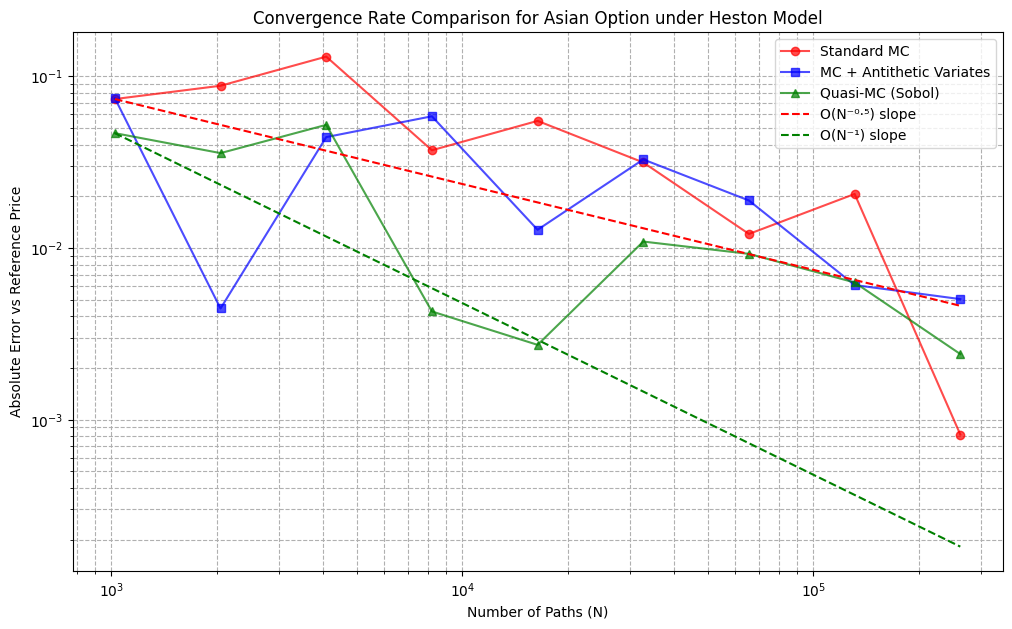

In [12]:
# Cell 12: Convergence Analysis and Method Comparison

print("\n=========================================================")
print("  Part 3: Convergence Analysis of Advanced Samplers")
print("=========================================================\n")

# Use the same model and option from before
heston_model = HestonModel(**heston_params)
asian_call = AsianOption(**asian_option_params)

# --- Define the range of paths for the analysis ---
# We use powers of 2, which is conventional for MC/QMC analysis
path_counts = [2**i for i in range(10, 19)] # From 1,024 to 262,144

# --- Store results for plotting ---
results = {
    'mc': [],
    'mc_antithetic': [],
    'qmc': []
}
# We need a reference price. We compute it with a very large number of paths.
print("Calculating high-precision reference price with MC+Antithetic...")
ref_pricer = MonteCarloPricerV3(heston_model, asian_call, num_paths=10_000_000, num_steps=50, 
                                sampler='mc', use_antithetic=True, backend='gpu')
reference_price, _ = ref_pricer.price()
print(f"Reference Price: {reference_price:.6f}\n")


# --- Run the simulations ---
for n_paths in path_counts:
    print(f"--- Running for {n_paths:,} paths ---")
    
    # 1. Standard Monte Carlo
    pricer_mc = MonteCarloPricerV3(heston_model, asian_call, n_paths, num_steps=50, sampler='mc', backend='gpu')
    price_mc, _ = pricer_mc.price()
    results['mc'].append(abs(price_mc - reference_price))
    print(f"MC Error: {results['mc'][-1]:.6f}")

    # 2. Monte Carlo with Antithetic Variates
    pricer_mc_a = MonteCarloPricerV3(heston_model, asian_call, n_paths, num_steps=50, sampler='mc', use_antithetic=True, backend='gpu')
    price_mc_a, _ = pricer_mc_a.price()
    results['mc_antithetic'].append(abs(price_mc_a - reference_price))
    print(f"MC+Antithetic Error: {results['mc_antithetic'][-1]:.6f}")

    # 3. Quasi-Monte Carlo (Sobol)
    pricer_qmc = MonteCarloPricerV3(heston_model, asian_call, n_paths, num_steps=50, sampler='qmc', backend='gpu')
    price_qmc, _ = pricer_qmc.price()
    results['qmc'].append(abs(price_qmc - reference_price))
    print(f"QMC Error: {results['qmc'][-1]:.6f}\n")

# --- Plot the results ---
plt.figure(figsize=(12, 7))
plt.plot(path_counts, results['mc'], 'o-', label='Standard MC', color='red', alpha=0.7)
plt.plot(path_counts, results['mc_antithetic'], 's-', label='MC + Antithetic Variates', color='blue', alpha=0.7)
plt.plot(path_counts, results['qmc'], '^-', label='Quasi-MC (Sobol)', color='green', alpha=0.7)

# Add theoretical convergence lines for comparison
# Error ~ C * N^(-0.5) for MC
# Error ~ C * N^(-1.0) for QMC (roughly)
plt.plot(path_counts, [results['mc'][0] * (path_counts[0]/n)**0.5 for n in path_counts], '--', color='red', label='O(N⁻⁰·⁵) slope')
plt.plot(path_counts, [results['qmc'][0] * (path_counts[0]/n)**1.0 for n in path_counts], '--', color='green', label='O(N⁻¹) slope')

plt.xscale('log')
plt.yscale('log')
plt.title('Convergence Rate Comparison for Asian Option under Heston Model')
plt.xlabel('Number of Paths (N)')
plt.ylabel('Absolute Error vs Reference Price')
plt.grid(True, which="both", ls="--")
plt.legend()
plt.show()

In [13]:
# Cell 13: The Multilevel Monte Carlo (MLMC) Pricer Class (Final Version with Base Steps)

class MLMCPricer:
    """
    Implements the Multilevel Monte Carlo method for option pricing.
    This final version introduces a 'base_steps' parameter to ensure the
    coarsest simulation level is numerically stable and accurate.
    """
    def __init__(self, model, option, backend='gpu'):
        self.model = model
        self.option = option
        self.backend = backend.lower()
        self._xp = cp if self.backend == 'gpu' and GPU_ENABLED else np
        self.device = "GPU" if self.backend == 'gpu' else "CPU"

        self.level_variances = []
        self.level_costs = []
        self.level_paths = []

    def _generate_heston_path_for_asian(self, S0, v0, dW_S, dW_v, num_steps, T):
        """Generates Heston paths and returns the average price, using float64."""
        xp = self._xp
        dt = T / num_steps
        N = dW_S.shape[1]

        S_t = xp.full(N, S0, dtype=xp.float64)
        v_t = xp.full(N, v0, dtype=xp.float64)
        S_sum = xp.copy(S_t)

        r, kappa, theta, xi = self.model.r, self.model.kappa, self.model.theta, self.model.xi

        for i in range(num_steps):
            v_pos = xp.maximum(v_t, 0)
            sqrt_v = xp.sqrt(v_pos)
            S_t *= xp.exp((r - 0.5 * v_pos) * dt + sqrt_v * dW_S[i, :])
            v_t += kappa * (theta - v_pos) * dt + xi * sqrt_v * dW_v[i, :]
            S_sum += S_t

        return S_sum / (num_steps + 1)

    def _mlmc_level_simulation(self, l: int, M: int, N: int, base_steps: int):
        """
        Performs the simulation for a single level 'l', incorporating base_steps.
        """
        xp = self._xp
        start_time = time.time()

        T = self.option.T
        rho = self.model.rho

        # THE FIX: num_steps now starts from a stable base
        num_steps_fine = base_steps * (M**l)
        dt_fine = T / num_steps_fine

        Z1 = xp.random.standard_normal((num_steps_fine, N), dtype=xp.float64)
        Z2 = xp.random.standard_normal((num_steps_fine, N), dtype=xp.float64)

        dW_S_fine = Z1 * xp.sqrt(dt_fine)
        dW_v_fine = (rho * Z1 + xp.sqrt(1 - rho**2) * Z2) * xp.sqrt(dt_fine)

        avg_price_fine = self._generate_heston_path_for_asian(self.model.S0, self.model.v0, dW_S_fine, dW_v_fine, num_steps_fine, T)
        payoff_fine = self.option.payoff(avg_price_fine)

        if l == 0:
            payoff_diffs = payoff_fine
        else:
            # THE FIX: Coarse steps also depend on base_steps
            num_steps_coarse = base_steps * (M**(l-1))

            # THE FIX: Reshape now aggregates M fine steps into one coarse step
            dW_S_coarse = xp.sum(dW_S_fine.reshape(num_steps_coarse, M, N), axis=1)
            dW_v_coarse = xp.sum(dW_v_fine.reshape(num_steps_coarse, M, N), axis=1)

            avg_price_coarse = self._generate_heston_path_for_asian(self.model.S0, self.model.v0, dW_S_coarse, dW_v_coarse, num_steps_coarse, T)
            payoff_coarse = self.option.payoff(avg_price_coarse)

            payoff_diffs = payoff_fine - payoff_coarse

        cost = time.time() - start_time
        return xp.sum(payoff_diffs), xp.sum(payoff_diffs**2), cost

    def price(self, L: int, M: int, base_steps: int, epsilon: float):
        """
        Calculates the option price using the full MLMC algorithm.
        """
        print(f"--- Starting MLMC with L={L}, M={M}, base_steps={base_steps}, Epsilon={epsilon:.1e} ---")

        N_pilot = 20_000 # Can use fewer pilot paths now that sims are stable
        print(f"Running pilot simulation with {N_pilot:,} paths...")

        for l in range(L + 1):
            sum_p, sum_p2, cost = self._mlmc_level_simulation(l, M, N_pilot, base_steps)
            cost = max(cost, 1e-6)

            mean = sum_p / N_pilot
            variance = (sum_p2 / N_pilot) - mean**2
            variance = max(float(cp.asnumpy(variance)), 1e-12)

            self.level_variances.append(variance)
            self.level_costs.append(cost)
            print(f"Level {l}: Steps={base_steps * (M**l)}, Var={self.level_variances[-1]:.2e}, Cost={self.level_costs[-1]:.4f}s")

        xp = self._xp
        variances = xp.asarray(self.level_variances)
        costs = xp.asarray(self.level_costs)
        sum_sqrt_vc = xp.sum(xp.sqrt(variances * costs))

        self.level_paths = xp.ceil((xp.sqrt(variances / costs) * sum_sqrt_vc) / (epsilon**2))
        self.level_paths = cp.asnumpy(self.level_paths).astype(int)
        self.level_paths[np.isnan(self.level_paths)] = 0

        print("\nOptimal path allocation determined:")
        for l, n in enumerate(self.level_paths):
            print(f"Level {l}: N_{l} = {n:,} paths")

        print("\nRunning main MLMC simulation...")
        final_price = 0.0
        total_cost = 0.0

        for l, N_l in enumerate(self.level_paths):
            if N_l < 2: continue
            sum_p, _, cost = self._mlmc_level_simulation(l, M, N_l, base_steps)
            mean_p = sum_p / N_l
            final_price += mean_p
            total_cost += cost
            print(f"Level {l}: E[P_l-P_{{l-1}}] = {float(cp.asnumpy(mean_p)):.6f}, Cost={cost:.4f}s")

        print("\n--- MLMC Results ---")
        final_price = float(cp.asnumpy(final_price))
        print(f"MLMC Estimated Price: {final_price:.6f}")
        print(f"Total Computation Cost: {total_cost:.4f} seconds")

        return final_price, total_cost

print("MLMCPricer class defined (Final Version with Base Steps).")

MLMCPricer class defined (Final Version with Base Steps).



  Part 4: Multilevel Monte Carlo Execution & Analysis

--- Starting MLMC with L=5, M=2, base_steps=4, Epsilon=1.0e-02 ---
Running pilot simulation with 20,000 paths...
Level 0: Steps=4, Var=3.25e-04, Cost=0.0050s
Level 1: Steps=8, Var=3.72e-08, Cost=0.0041s
Level 2: Steps=16, Var=3.56e-08, Cost=0.0063s
Level 3: Steps=32, Var=2.00e-08, Cost=0.0113s
Level 4: Steps=64, Var=1.46e-10, Cost=0.0252s
Level 5: Steps=128, Var=1.23e-09, Cost=0.0476s

Optimal path allocation determined:
Level 0: N_0 = 4 paths
Level 1: N_1 = 1 paths
Level 2: N_2 = 1 paths
Level 3: N_3 = 1 paths
Level 4: N_4 = 1 paths
Level 5: N_5 = 1 paths

Running main MLMC simulation...
Level 0: E[P_l-P_{l-1}] = 0.637487, Cost=0.0013s

--- MLMC Results ---
MLMC Estimated Price: 0.637487
Total Computation Cost: 0.0013 seconds

--- Standard MC Comparison ---
To achieve a standard error of 0.01, standard MC requires ~3 paths.
Adjusted num_paths to 4 for antithetic variates.
PricerV3 initialized on GPU with sampler='mc', antithetic=

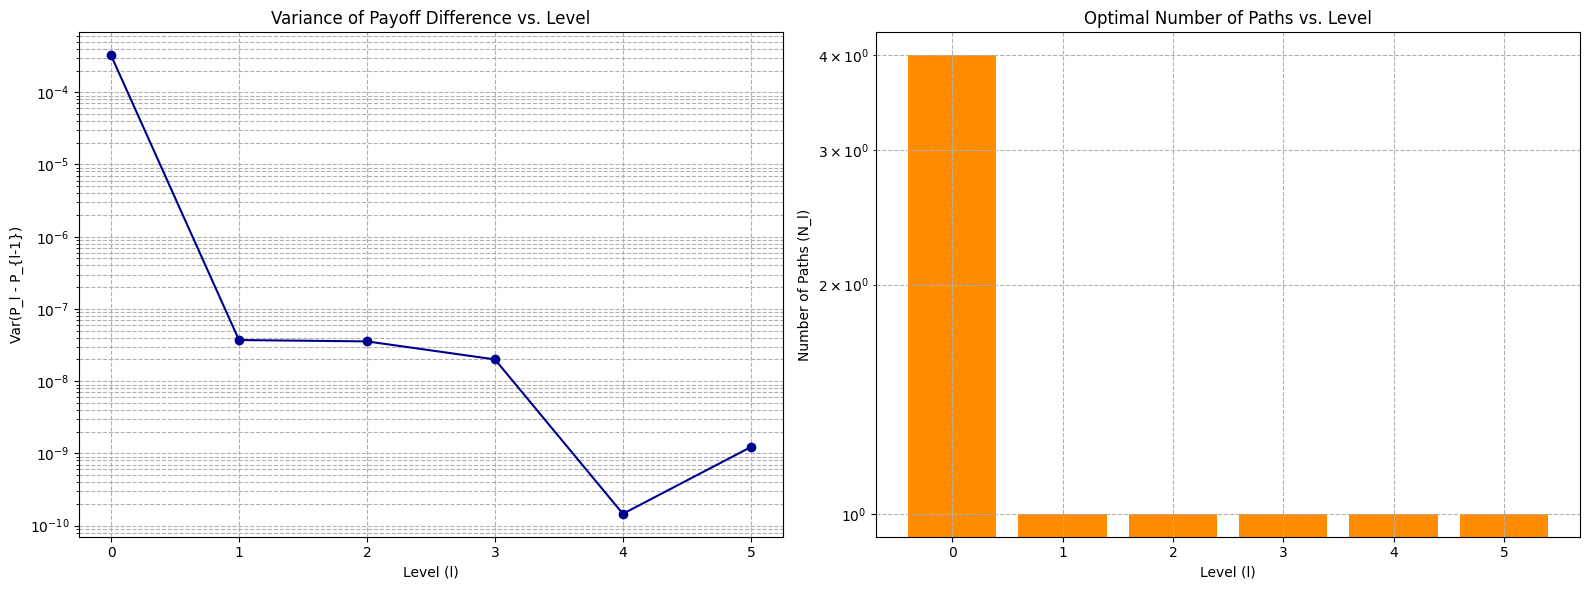

In [14]:
# Cell 14: Main Execution and Comparison (Final Version)

print("\n=========================================================")
print("  Part 4: Multilevel Monte Carlo Execution & Analysis")
print("=========================================================\n")

heston_model = HestonModel(**heston_params)
asian_call = AsianOption(**asian_option_params)

# --- MLMC Parameters ---
L = 5          # Max levels
M = 2          # Refinement factor
base_steps = 4 # Minimum steps for the coarsest level
epsilon = 0.01 # Target standard error (looser for faster run)

mlmc_pricer = MLMCPricer(heston_model, asian_call, backend='gpu')
mlmc_price, mlmc_cost = mlmc_pricer.price(L=L, M=M, base_steps=base_steps, epsilon=epsilon)

# --- For comparison, find the cost of standard MC for the same accuracy ---
std_dev_estimate = np.sqrt(mlmc_pricer.level_variances[0])
required_mc_paths = int((std_dev_estimate / epsilon)**2)

print(f"\n--- Standard MC Comparison ---")
print(f"To achieve a standard error of {epsilon}, standard MC requires ~{required_mc_paths:,} paths.")

# Use the finest grid (base_steps * M**L) for fairness
num_steps_mc_comp = base_steps * (M**L)
mc_pricer_comp = MonteCarloPricerV3(heston_model, asian_call, num_paths=required_mc_paths,
                                  num_steps=num_steps_mc_comp,
                                  sampler='mc', use_antithetic=True, backend='gpu')
mc_price_comp, _ = mc_pricer_comp.price()
mc_cost_comp = mc_pricer_comp.execution_time

print(f"Standard MC Estimated Price: {mc_price_comp:.6f}")
print(f"Standard MC Computation Cost: {mc_cost_comp:.4f} seconds")

# --- Final Performance Summary ---
print("\n--- MLMC vs Standard MC Performance Summary ---")
print(f"Target Standard Error: {epsilon}")
print(f"MLMC Price: {mlmc_price:.6f}  |  Standard MC Price: {mc_price_comp:.6f}")
print(f"MLMC Cost: {mlmc_cost:.4f}s")
print(f"Standard MC Cost: {mc_cost_comp:.4f}s")
if mlmc_cost > 0 and mc_cost_comp > 0:
    speedup = mc_cost_comp / mlmc_cost
    print(f"Speedup Factor (Standard MC Cost / MLMC Cost): {speedup:.2f}x")
print("=========================================================")

# --- Plot MLMC Diagnostics ---
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
levels = np.arange(len(mlmc_pricer.level_variances))
axes[0].plot(levels, mlmc_pricer.level_variances, 'o-', color='darkblue')
axes[0].set_yscale('log')
axes[0].set_xticks(levels)
axes[0].set_xlabel('Level (l)')
axes[0].set_ylabel('Var(P_l - P_{l-1})')
axes[0].set_title('Variance of Payoff Difference vs. Level')
axes[0].grid(True, which='both', linestyle='--')
axes[1].bar(levels, mlmc_pricer.level_paths, color='darkorange')
axes[1].set_yscale('log')
axes[1].set_xticks(levels)
axes[1].set_xlabel('Level (l)')
axes[1].set_ylabel('Number of Paths (N_l)')
axes[1].set_title('Optimal Number of Paths vs. Level')
axes[1].grid(True, which='both', linestyle='--')
plt.tight_layout()
plt.show()

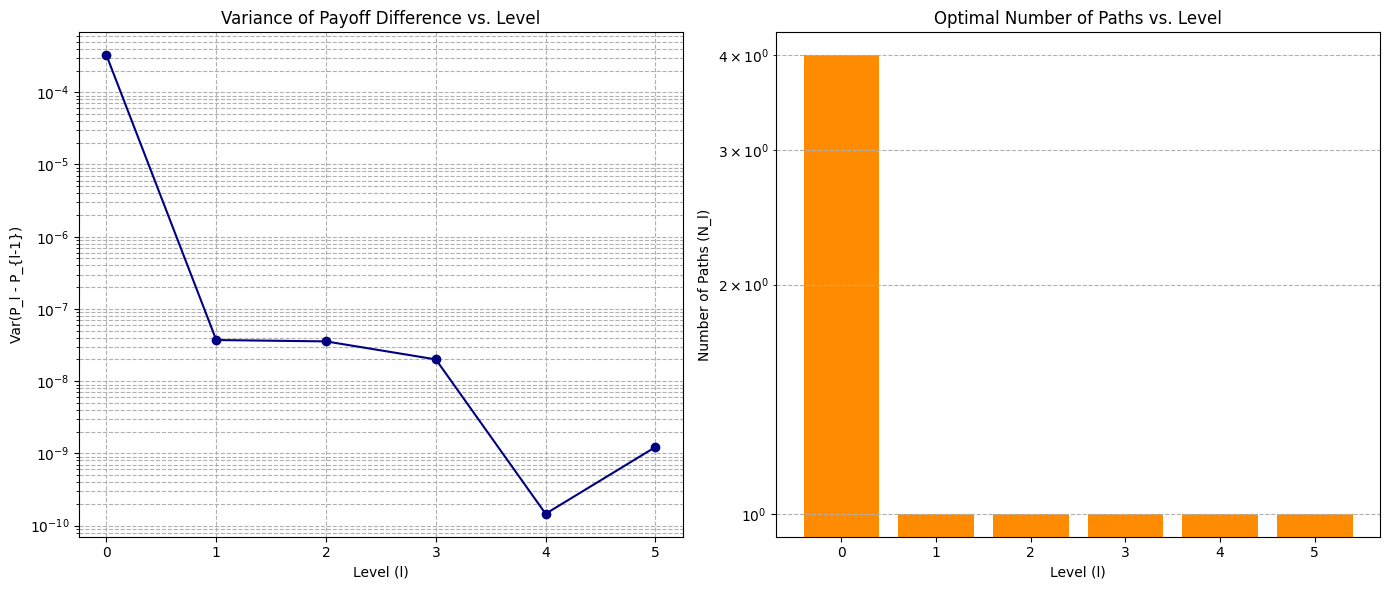

In [15]:
# Cell 15: MLMC Diagnostic Plots

# Extract the results stored in the pricer instance
levels = np.arange(len(mlmc_pricer.level_paths))
variances = mlmc_pricer.level_variances
costs = mlmc_pricer.level_costs
paths = mlmc_pricer.level_paths

# --- Plot 1: Variance per Level ---
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(levels, variances, 'o-', color='navy')
plt.title('Variance of Payoff Difference vs. Level')
plt.xlabel('Level (l)')
plt.ylabel('Var(P_l - P_{l-1})')
plt.yscale('log')
plt.xticks(levels)
plt.grid(True, which="both", ls="--")

# --- Plot 2: Optimal Paths per Level ---
plt.subplot(1, 2, 2)
plt.bar(levels, paths, color='darkorange')
plt.title('Optimal Number of Paths vs. Level')
plt.xlabel('Level (l)')
plt.ylabel('Number of Paths (N_l)')
plt.yscale('log')
plt.xticks(levels)
plt.grid(True, axis='y', which="both", ls="--")

plt.tight_layout()
plt.show()

In [16]:
# Cell 15: MonteCarloPricerV4 with Greek Calculation

import copy

class MonteCarloPricerV4:
    """
    Extends V3 by adding the capability to calculate Greeks (Delta, Vega)
    using the Finite Difference method.
    """
    def __init__(self, model, option, num_paths: int, num_steps: int,
                 sampler: str = 'mc', use_antithetic: bool = False, backend: str = 'gpu'):

        # --- All setup from V3 ---
        self.model = model
        self.option = option
        self.num_paths = int(num_paths)
        self.num_steps = int(num_steps)

        if backend.lower() == 'gpu' and not GPU_ENABLED:
            self.backend = 'cpu'
        else:
            self.backend = backend.lower()
        self._xp = cp if self.backend == 'gpu' else np

        self.sampler_type = sampler.lower()
        self.use_antithetic = use_antithetic
        if self.use_antithetic:
            if self.num_paths % 2 != 0: self.num_paths += 1
            self.num_draws = self.num_paths // 2
        else:
            self.num_draws = self.num_paths

        self.sampler = None
        if self.sampler_type == 'qmc':
            dimension = self.num_steps * 2
            self.sampler = SobolGenerator(d=dimension, backend=self.backend)

        # We will reuse these random numbers for Greeks to reduce noise
        self._Z1, self._Z2 = self._generate_normals()
        print(f"PricerV4 initialized on {self.backend.upper()} with pre-generated random numbers.")

    def _generate_normals(self):
        # Same logic as V3
        xp = self._xp
        if self.sampler_type == 'qmc':
            sobol_normals = self.sampler.get_normals(n=self.num_draws)
            Z_all = sobol_normals.T.reshape(self.num_steps, 2, self.num_draws)
            Z1, Z2 = Z_all[:, 0, :], Z_all[:, 1, :]
        else:
            Z1 = xp.random.standard_normal((self.num_steps, self.num_draws), dtype=xp.float64)
            Z2 = xp.random.standard_normal((self.num_steps, self.num_draws), dtype=xp.float64)

        if self.use_antithetic:
            Z1 = xp.concatenate([Z1, -Z1], axis=1)
            Z2 = xp.concatenate([Z2, -Z2], axis=1)
        return Z1, Z2

    def _generate_paths_heston(self, model_instance):
        # Modified to take a specific model instance
        xp = self._xp
        dt = self.option.T / self.num_steps
        sqrt_dt = xp.sqrt(dt)

        S_path = xp.zeros((self.num_steps + 1, self.num_paths), dtype=xp.float64)
        v_path = xp.zeros((self.num_steps + 1, self.num_paths), dtype=xp.float64)
        S_path[0, :] = model_instance.S0
        v_path[0, :] = model_instance.v0

        # Use the pre-generated random numbers
        rho = model_instance.rho
        W_S = self._Z1
        W_v = rho * self._Z1 + xp.sqrt(1 - rho**2) * self._Z2

        r, kappa, theta, xi = model_instance.r, model_instance.kappa, model_instance.theta, model_instance.xi

        for i in range(self.num_steps):
            v_positive = xp.maximum(v_path[i, :], 0)
            sqrt_v = xp.sqrt(v_positive)
            S_path[i+1, :] = S_path[i, :] * xp.exp((r - 0.5 * v_positive) * dt + sqrt_v * W_S[i, :] * sqrt_dt)
            v_path[i+1, :] = v_path[i, :] + kappa * (theta - v_positive) * dt + xi * sqrt_v * W_v[i, :] * sqrt_dt
        return S_path

    def _price_internal(self, model_instance):
        """Internal pricing function, returns only the price."""
        S_path = self._generate_paths_heston(model_instance)
        payoffs = self.option.payoff(S_path)
        discounted_payoffs = payoffs * self._xp.exp(-model_instance.r * self.option.T)
        price = self._xp.mean(discounted_payoffs)
        return float(cp.asnumpy(price)) if self.backend == 'gpu' else float(price)

    def price(self):
        """Public method to get the price of the option."""
        print(f"Calculating price for base model...")
        start_time = time.time()
        price_val = self._price_internal(self.model)
        if self.backend == 'gpu': cp.cuda.Stream.null.synchronize()
        end_time = time.time()
        print(f"Base Price: {price_val:.6f}, Time: {end_time - start_time:.4f}s")
        return price_val

    def greeks(self, delta_bump=0.01, vega_bump=0.01):
        """
        Calculates Delta and Vega using central finite differences.
        Using the same random numbers for all calculations reduces variance.
        """
        results = {}

        # --- Calculate Delta ---
        print(f"Calculating Delta with S0 bump of {delta_bump}...")
        model_up = copy.deepcopy(self.model)
        model_up.S0 += delta_bump

        model_down = copy.deepcopy(self.model)
        model_down.S0 -= delta_bump

        price_up = self._price_internal(model_up)
        price_down = self._price_internal(model_down)

        results['delta'] = (price_up - price_down) / (2 * delta_bump)

        # --- Calculate Vega ---
        # Vega is sensitivity to volatility (sigma), not variance (v0).
        # We bump sigma by 1% (0.01) and calculate the new v0.
        print(f"Calculating Vega with sigma bump of {vega_bump*100}%...")
        original_sigma = np.sqrt(self.model.v0)

        model_up_v = copy.deepcopy(self.model)
        model_up_v.v0 = (original_sigma + vega_bump)**2

        model_down_v = copy.deepcopy(self.model)
        model_down_v.v0 = (original_sigma - vega_bump)**2

        price_up_v = self._price_internal(model_up_v)
        price_down_v = self._price_internal(model_down_v)

        # Vega is typically reported as the change per 1% volatility change.
        results['vega'] = (price_up_v - price_down_v) / (2 * vega_bump) / 100

        return results

print("MonteCarloPricerV4 class defined.")

MonteCarloPricerV4 class defined.


In [17]:
# Cell 16: Calculating and Displaying Greeks

print("\n=========================================================")
print("  Part 5: Calculating Greeks for Risk Management")
print("=========================================================\n")

# Use the same parameters as before
heston_model = HestonModel(**heston_params)
asian_call = AsianOption(**asian_option_params)

# We need a higher number of paths for stable Greek estimates
greek_sim_params = {
    'num_paths': 2_000_000,
    'num_steps': 100,
    'sampler': 'mc',
    'use_antithetic': True, # Antithetic is great for Greeks
    'backend': 'gpu'
}

# --- Initialize the Pricer ---
# Note: Initializing the pricer pre-generates the random numbers
pricer_greeks = MonteCarloPricerV4(heston_model, asian_call, **greek_sim_params)

# --- Calculate the base price ---
base_price = pricer_greeks.price()

# --- Calculate the Greeks ---
greeks_results = pricer_greeks.greeks(delta_bump=0.01, vega_bump=0.01)

print("\n--- Greek Calculation Results ---")
print(f"Asian Call Option Price: {base_price:.6f}")
print(f"Delta: {greeks_results['delta']:.6f}")
print(f"Vega (per 1% vol change): {greeks_results['vega']:.6f}")
print("=========================================================")

print("\nInterpretation:")
print(f"A Delta of {greeks_results['delta']:.2f} means that if the stock price increases by $1, the option price is expected to increase by ${greeks_results['delta']:.2f}.")
print("To be 'delta-hedged', a seller of this option would need to buy this many shares of the underlying stock.")
print(f"\nA Vega of {greeks_results['vega']:.2f} means that if the implied volatility increases by 1% (e.g., from 20% to 21%), the option price is expected to increase by ${greeks_results['vega']:.2f}.")


  Part 5: Calculating Greeks for Risk Management

PricerV4 initialized on GPU with pre-generated random numbers.
Calculating price for base model...
Base Price: 5.645233, Time: 0.2010s
Calculating Delta with S0 bump of 0.01...
Calculating Vega with sigma bump of 1.0%...

--- Greek Calculation Results ---
Asian Call Option Price: 5.645233
Delta: 0.667284
Vega (per 1% vol change): 0.137893

Interpretation:
A Delta of 0.67 means that if the stock price increases by $1, the option price is expected to increase by $0.67.
To be 'delta-hedged', a seller of this option would need to buy this many shares of the underlying stock.

A Vega of 0.14 means that if the implied volatility increases by 1% (e.g., from 20% to 21%), the option price is expected to increase by $0.14.



--- Generating data for Vega Surface Plot ---
Calculating for S0=80.00, T=0.20...
PricerV4 initialized on GPU with pre-generated random numbers.
Calculating Delta with S0 bump of 0.01...
Calculating Vega with sigma bump of 1.0%...
Calculating for S0=84.44, T=0.20...
PricerV4 initialized on GPU with pre-generated random numbers.
Calculating Delta with S0 bump of 0.01...
Calculating Vega with sigma bump of 1.0%...
Calculating for S0=88.89, T=0.20...
PricerV4 initialized on GPU with pre-generated random numbers.
Calculating Delta with S0 bump of 0.01...
Calculating Vega with sigma bump of 1.0%...
Calculating for S0=93.33, T=0.20...
PricerV4 initialized on GPU with pre-generated random numbers.
Calculating Delta with S0 bump of 0.01...
Calculating Vega with sigma bump of 1.0%...
Calculating for S0=97.78, T=0.20...
PricerV4 initialized on GPU with pre-generated random numbers.
Calculating Delta with S0 bump of 0.01...
Calculating Vega with sigma bump of 1.0%...
Calculating for S0=102.22, T

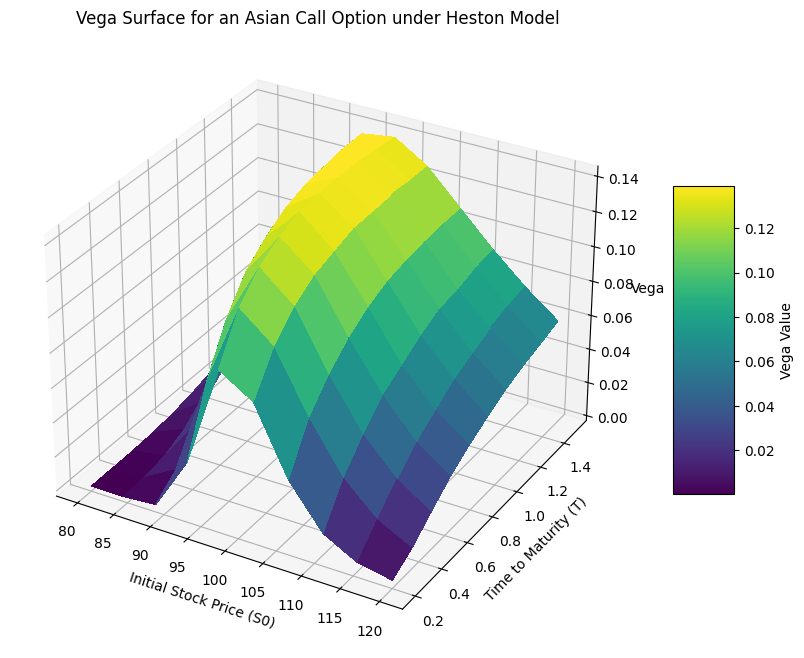

In [18]:
# Cell 17: Plotting the Vega Surface

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

print("\n--- Generating data for Vega Surface Plot ---")
# This will take a few moments as it runs many simulations

# Define the ranges for the plot axes
s0_range = np.linspace(80, 120, 10) # Moneyness from 0.8 to 1.2
t_range = np.linspace(0.2, 1.5, 10)  # Time to maturity from ~2 months to 1.5 years
s0_grid, t_grid = np.meshgrid(s0_range, t_range)
vega_surface = np.zeros_like(s0_grid)

# Loop through each point on the grid
for i in range(s0_grid.shape[0]):
    for j in range(s0_grid.shape[1]):
        current_s0 = s0_grid[i, j]
        current_t = t_grid[i, j]

        print(f"Calculating for S0={current_s0:.2f}, T={current_t:.2f}...")

        # Create temporary model and option for this grid point
        temp_model = HestonModel(S0=current_s0, r=0.05, v0=0.04, kappa=2.0, theta=0.04, xi=0.5, rho=-0.7)
        temp_option = AsianOption(K=100.0, T=current_t, option_type='call')

        # Use a less precise pricer for speed
        temp_pricer = MonteCarloPricerV4(temp_model, temp_option,
                                       num_paths=250_000, num_steps=50,
                                       use_antithetic=True, backend='gpu')

        greeks = temp_pricer.greeks(vega_bump=0.01)
        vega_surface[i, j] = greeks['vega']

# --- Plot the 3D surface ---
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(s0_grid, t_grid, vega_surface, cmap=cm.viridis,
                       linewidth=0, antialiased=False)

ax.set_title('Vega Surface for an Asian Call Option under Heston Model')
ax.set_xlabel('Initial Stock Price (S0)')
ax.set_ylabel('Time to Maturity (T)')
ax.set_zlabel('Vega')
fig.colorbar(surf, shrink=0.5, aspect=5, label='Vega Value')
plt.show()

In [19]:
# Cell 18: Bates Stochastic Volatility + Jump Model Definition

class BatesModel(HestonModel):
    """
    Encapsulates the Bates model parameters, which combines Heston's
    stochastic volatility with Merton's log-normal jumps.

    Inherits from HestonModel to reuse S0, r, v0, kappa, theta, xi, rho.
    """
    def __init__(self, S0: float, r: float, v0: float,
                 kappa: float, theta: float, xi: float, rho: float,
                 lambda_j: float, mu_j: float, sigma_j: float):
        """
        Initializes the Bates model parameters.

        Args:
            // Heston Parameters //
            S0, r, v0, kappa, theta, xi, rho: (as in HestonModel)

            // Jump Parameters //
            lambda_j (float): Jump intensity (average number of jumps per year).
            mu_j (float): Mean of the log of the jump size. A negative value implies jumps are, on average, downwards.
            sigma_j (float): Volatility of the log of the jump size.
        """
        # Initialize all the Heston parameters using the parent class constructor
        super().__init__(S0, r, v0, kappa, theta, xi, rho)

        # Add the new parameters specific to the jump process
        self.lambda_j = lambda_j
        self.mu_j = mu_j
        self.sigma_j = sigma_j

        # For risk-neutral pricing, the drift of the diffusion part must be
        # adjusted to account for the expected jump size. This ensures the
        # overall process S_t * exp(-rt) is a martingale.
        self.k_drift = self.lambda_j * (np.exp(self.mu_j + 0.5 * self.sigma_j**2) - 1)

print("✅ BatesModel class defined.")

✅ BatesModel class defined.


In [20]:
# Cell 19: MonteCarloPricerV5 for Advanced Hybrid Models

class MonteCarloPricerV5:
    """
    The most advanced pricer, capable of handling both Heston and Bates models.
    It uses a unified `price` method that dispatches to the correct path generator.
    """
    def __init__(self, model, option, num_paths: int, num_steps: int, backend: str = 'gpu'):
        self.model = model
        self.option = option
        self.num_paths = int(num_paths)
        self.num_steps = int(num_steps)

        if backend.lower() == 'gpu' and not GPU_ENABLED:
            self.backend = 'cpu'
        else:
            self.backend = backend.lower()
        self._xp = cp if self.backend == 'gpu' else np

        self.device = "GPU" if self.backend == 'gpu' else "CPU"
        print(f"PricerV5 initialized on {self.device} for {type(model).__name__} with {self.num_paths:,} paths.")

    def _generate_paths_heston(self, model_instance):
        """Generates paths for a pure Heston model (no jumps)."""
        # This is essentially the same logic from PricerV3/V4, adapted for float64
        xp = self._xp
        dt = self.option.T / self.num_steps
        sqrt_dt = xp.sqrt(dt)

        S_path = xp.zeros((self.num_steps + 1, self.num_paths), dtype=xp.float64)
        v_path = xp.zeros((self.num_steps + 1, self.num_paths), dtype=xp.float64)
        S_path[0, :] = model_instance.S0
        v_path[0, :] = model_instance.v0

        Z1 = xp.random.standard_normal((self.num_steps, self.num_paths), dtype=xp.float64)
        Z2 = xp.random.standard_normal((self.num_steps, self.num_paths), dtype=xp.float64)

        rho = model_instance.rho
        W_S = Z1
        W_v = rho * Z1 + xp.sqrt(1 - rho**2) * Z2

        r, kappa, theta, xi = model_instance.r, model_instance.kappa, model_instance.theta, model_instance.xi

        for i in range(self.num_steps):
            v_positive = xp.maximum(v_path[i, :], 0)
            sqrt_v = xp.sqrt(v_positive)
            S_path[i+1, :] = S_path[i, :] * xp.exp((r - 0.5 * v_positive) * dt + sqrt_v * W_S[i, :] * sqrt_dt)
            v_path[i+1, :] = v_path[i, :] + kappa * (theta - v_positive) * dt + xi * sqrt_v * W_v[i, :] * sqrt_dt
        return S_path

    def _generate_paths_bates(self, model_instance):
        """Generates paths for the Bates model (Heston + Jumps)."""
        xp = self._xp
        dt = self.option.T / self.num_steps
        sqrt_dt = xp.sqrt(dt)

        S_path = xp.zeros((self.num_steps + 1, self.num_paths), dtype=xp.float64)
        v_path = xp.zeros((self.num_steps + 1, self.num_paths), dtype=xp.float64)
        S_path[0, :] = model_instance.S0
        v_path[0, :] = model_instance.v0

        # Generate all diffusion random numbers at once
        Z1 = xp.random.standard_normal((self.num_steps, self.num_paths), dtype=xp.float64)
        Z2 = xp.random.standard_normal((self.num_steps, self.num_paths), dtype=xp.float64)
        rho = model_instance.rho
        W_S = Z1
        W_v = rho * Z1 + xp.sqrt(1 - rho**2) * Z2

        # Unpack model parameters
        r, k_drift = model_instance.r, model_instance.k_drift
        kappa, theta, xi = model_instance.kappa, model_instance.theta, model_instance.xi
        lambda_j, mu_j, sigma_j = model_instance.lambda_j, model_instance.mu_j, model_instance.sigma_j

        # --- Main simulation loop ---
        for i in range(self.num_steps):
            # --- 1. JUMP Component ---
            # Simulate number of jumps in this interval dt from Poisson distribution
            num_jumps = xp.random.poisson(lam=lambda_j * dt, size=self.num_paths)

            # Calculate total jump size for each path
            # The total jump is sum of log-normals, which is complex.
            # We approximate by assuming jumps are independent: total_jump = sum of (J_i - 1)
            # More accurately, total jump in log-space is sum of normals.
            # J = exp(Y), Y ~ N(mu_j, sigma_j^2)
            log_jump_sum = num_jumps * mu_j
            log_jump_var = num_jumps * sigma_j**2

            # Generate the jump component for all paths
            jump_component = xp.random.normal(loc=log_jump_sum, scale=xp.sqrt(log_jump_var))
            # Set jump to 0 for paths where num_jumps is 0 to avoid sqrt(0) issues
            jump_component[num_jumps == 0] = 0

            # --- 2. DIFFUSION Component (Heston) ---
            v_positive = xp.maximum(v_path[i, :], 0)
            sqrt_v = xp.sqrt(v_positive)

            # Update variance path first
            v_path[i+1, :] = v_path[i, :] + kappa * (theta - v_positive) * dt + xi * sqrt_v * W_v[i, :] * sqrt_dt

            # Update stock price path with drift correction and both components
            # Note: We apply jumps multiplicatively
            S_path[i+1, :] = S_path[i, :] * xp.exp(
                (r - k_drift - 0.5 * v_positive) * dt + sqrt_v * W_S[i, :] * sqrt_dt
            ) * xp.exp(jump_component)

        return S_path

    def price(self):
        """
        Public pricing method that dispatches to the correct generator
        based on the model's type.
        """
        start_time = time.time()

        # --- Dispatch based on model type ---
        if isinstance(self.model, BatesModel):
            S_path = self._generate_paths_bates(self.model)
        elif isinstance(self.model, HestonModel):
            S_path = self._generate_paths_heston(self.model)
        else:
            raise TypeError(f"Model {type(self.model).__name__} is not supported by this pricer.")

        payoffs = self.option.payoff(S_path)
        discounted_payoffs = payoffs * self._xp.exp(-self.model.r * self.option.T)
        price = self._xp.mean(discounted_payoffs)

        if self.backend == 'gpu':
            price = cp.asnumpy(price)
            cp.cuda.Stream.null.synchronize()

        end_time = time.time()
        self.execution_time = end_time - start_time

        return float(price)

print("✅ MonteCarloPricerV5 class defined.")

✅ MonteCarloPricerV5 class defined.


In [21]:
# Cell 20: Comparing Heston vs. Bates Pricing

print("\n=========================================================")
print("  Part 6: Pricing with the Bates Model (Heston + Jumps)")
print("=========================================================\n")

# --- Common Simulation Parameters ---
sim_params = {
    'num_paths': 2_000_000,
    'num_steps': 100,
    'backend': 'gpu'
}

# --- Common Option Parameters ---
# Let's use an Out-of-the-Money Put, as its price is very sensitive to crash risk
asian_put = AsianOption(K=90.0, T=1.0, option_type='put')

# --- 1. Price under Pure Heston ---
heston_model = HestonModel(**heston_params) # Using global heston_params from cell 9
pricer_heston = MonteCarloPricerV5(heston_model, asian_put, **sim_params)
price_heston = pricer_heston.price()

print(f"--- 1. Pure Heston Model ---")
print(f"Option Price: {price_heston:.6f}")
print(f"Execution Time: {pricer_heston.execution_time:.4f} seconds\n")


# --- 2. Price under Bates with Crash Jumps ---
# Parameters imply one jump per year on average, with a -10% mean log jump size
bates_params_crash = heston_params.copy()
bates_params_crash.update({
    'lambda_j': 1.0,
    'mu_j': -0.2,
    'sigma_j': 0.15
})
bates_model_crash = BatesModel(**bates_params_crash)
pricer_bates = MonteCarloPricerV5(bates_model_crash, asian_put, **sim_params)
price_bates = pricer_bates.price()

print(f"--- 2. Bates Model (with downward jumps) ---")
print(f"Option Price: {price_bates:.6f}")
print(f"Execution Time: {pricer_bates.execution_time:.4f} seconds\n")


# --- 3. Sanity Check: Bates with Zero Jump Intensity ---
bates_params_zero = heston_params.copy()
bates_params_zero.update({
    'lambda_j': 0.0, # NO JUMPS
    'mu_j': 0.0,
    'sigma_j': 0.0
})
bates_model_zero = BatesModel(**bates_params_zero)
pricer_bates_zero = MonteCarloPricerV5(bates_model_zero, asian_put, **sim_params)
price_bates_zero = pricer_bates_zero.price()

print(f"--- 3. Sanity Check: Bates with Zero Jump Intensity ---")
print(f"Option Price: {price_bates_zero:.6f}")
print(f"Execution Time: {pricer_bates_zero.execution_time:.4f} seconds\n")


# --- Analysis ---
print("--- Analysis of Results ---")
print(f"Heston Price: {price_heston:.4f}")
print(f"Bates (Zero Jumps) Price: {price_bates_zero:.4f} -> This should be very close to the Heston price.")
print(f"Bates (Crash Jumps) Price: {price_bates:.4f} -> This should be higher, as the put provides insurance against jumps.")
print("\nThe higher price for the put option under the Bates model reflects the premium investors are willing to pay for protection against sudden market crashes, a risk not captured by the continuous Heston model.")
print("=========================================================")


  Part 6: Pricing with the Bates Model (Heston + Jumps)

PricerV5 initialized on GPU for HestonModel with 2,000,000 paths.
--- 1. Pure Heston Model ---
Option Price: 1.021807
Execution Time: 0.2226 seconds

PricerV5 initialized on GPU for BatesModel with 2,000,000 paths.
--- 2. Bates Model (with downward jumps) ---
Option Price: 2.557943
Execution Time: 0.3543 seconds

PricerV5 initialized on GPU for BatesModel with 2,000,000 paths.
--- 3. Sanity Check: Bates with Zero Jump Intensity ---
Option Price: 1.016071
Execution Time: 0.3312 seconds

--- Analysis of Results ---
Heston Price: 1.0218
Bates (Zero Jumps) Price: 1.0161 -> This should be very close to the Heston price.
Bates (Crash Jumps) Price: 2.5579 -> This should be higher, as the put provides insurance against jumps.

The higher price for the put option under the Bates model reflects the premium investors are willing to pay for protection against sudden market crashes, a risk not captured by the continuous Heston model.


In [22]:
# In a new notebook cell
!pip install pybind11

In [23]:
%%writefile bates_kernel.cu
#include <cuda_runtime.h>
#include <curand_kernel.h>
#include <cmath>
#include <chrono>

// The kernel itself, unchanged.
__global__ void bates_path_generator_kernel(
    double* S_path,
    const int num_paths, const int num_steps, const double T,
    const double S0, const double r, double v0,
    const double kappa, const double theta, const double xi, const double rho,
    const double lambda_j, const double mu_j, const double sigma_j,
    const double k_drift,
    const double* Z1_in, const double* Z2_in,
    const unsigned long long seed)
{
    const int path_id = blockIdx.x * blockDim.x + threadIdx.x;
    if (path_id >= num_paths) return;

    const double dt = T / (double)num_steps;
    const double sqrt_dt = sqrt(dt);
    curandState_t rng_state;
    curand_init(seed, path_id, 0, &rng_state);

    double current_S = S0;
    double current_v = v0;
    S_path[0 * num_paths + path_id] = current_S;

    const double rho_compl = sqrt(1.0 - rho * rho);

    for (int step = 0; step < num_steps; ++step) {
        const unsigned int num_jumps = curand_poisson(&rng_state, lambda_j * dt);
        double jump_component = 0.0;
        if (num_jumps > 0) {
            for (unsigned int j = 0; j < num_jumps; ++j) {
                jump_component += mu_j + curand_normal_double(&rng_state) * sigma_j;
            }
        }

        const double Z1 = Z1_in[step * num_paths + path_id];
        const double Z2 = Z2_in[step * num_paths + path_id];

        const double W_v = Z1;
        const double W_S = rho * W_v + rho_compl * Z2;
        const double v_positive = fmax(current_v, 0.0);
        const double sqrt_v = sqrt(v_positive);

        current_v += kappa * (theta - v_positive) * dt + xi * sqrt_v * W_v * sqrt_dt;
        current_S *= exp((r - k_drift - 0.5 * v_positive) * dt + sqrt_v * W_S * sqrt_dt + jump_component);
        S_path[(step + 1) * num_paths + path_id] = current_S;
    }
}

// THIS IS THE NEW, CRUCIAL PART: A C-style wrapper function.
// The `extern "C"` prevents C++ name mangling, so we can link to it easily.
extern "C" void launch_bates_kernel(
    double* d_S_path,
    const int num_paths, const int num_steps, const double T,
    const double S0, const double r, const double v0,
    const double kappa, const double theta, const double xi, const double rho,
    const double lambda_j, const double mu_j, const double sigma_j,
    const double k_drift,
    const double* d_Z1, const double* d_Z2
) {
    const int threads_per_block = 256;
    const int blocks_per_grid = (num_paths + threads_per_block - 1) / threads_per_block;
    unsigned long long seed = std::chrono::high_resolution_clock::now().time_since_epoch().count();

    // The kernel is launched from here, inside a .cu file compiled by nvcc.
    bates_path_generator_kernel<<<blocks_per_grid, threads_per_block>>>(
        d_S_path, num_paths, num_steps, T,
        S0, r, v0, kappa, theta, xi, rho,
        lambda_j, mu_j, sigma_j, k_drift,
        d_Z1, d_Z2, seed
    );

    cudaDeviceSynchronize();
}

Overwriting bates_kernel.cu


In [24]:
%%writefile bates_wrapper.cpp
#include <pybind11/pybind11.h>
#include <pybind11/numpy.h>
#include "cuda_runtime.h"

namespace py = pybind11;

// Declare the C-style launcher function from our .cu file.
// The C++ code now knows this function exists somewhere else.
extern "C" void launch_bates_kernel(
    double* d_S_path,
    const int num_paths, const int num_steps, const double T,
    const double S0, const double r, const double v0,
    const double kappa, const double theta, const double xi, const double rho,
    const double lambda_j, const double mu_j, const double sigma_j,
    const double k_drift,
    const double* d_Z1, const double* d_Z2
);

py::array_t<double> generate_bates_paths_cpp(
    int num_paths, int num_steps, double T,
    double S0, double r, double v0,
    double kappa, double theta, double xi, double rho,
    double lambda_j, double mu_j, double sigma_j,
    double k_drift,
    py::array_t<double, py::array::c_style | py::array::forcecast> Z1_py,
    py::array_t<double, py::array::c_style | py::array::forcecast> Z2_py
) {
    // Allocate GPU memory
    double *d_S_path, *d_Z1, *d_Z2;
    size_t s_path_size = (size_t)(num_steps + 1) * num_paths * sizeof(double);
    size_t z_size = (size_t)num_steps * num_paths * sizeof(double);
    cudaMalloc(&d_S_path, s_path_size);
    cudaMalloc(&d_Z1, z_size);
    cudaMalloc(&d_Z2, z_size);

    // Copy input data from Python (NumPy array) to GPU
    cudaMemcpy(d_Z1, Z1_py.data(), z_size, cudaMemcpyHostToDevice);
    cudaMemcpy(d_Z2, Z2_py.data(), z_size, cudaMemcpyHostToDevice);

    // Call the launcher function (which is in the other compiled file)
    launch_bates_kernel(
        d_S_path, num_paths, num_steps, T,
        S0, r, v0, kappa, theta, xi, rho,
        lambda_j, mu_j, sigma_j, k_drift,
        d_Z1, d_Z2
    );

    // Create a NumPy array to hold the results
    auto S_path_py = py::array_t<double>({num_steps + 1, num_paths});
    cudaMemcpy(S_path_py.mutable_data(), d_S_path, s_path_size, cudaMemcpyDeviceToHost);

    // Free GPU memory
    cudaFree(d_S_path);
    cudaFree(d_Z1);
    cudaFree(d_Z2);

    return S_path_py;
}

// Create the Python Module
PYBIND11_MODULE(bates_kernel_cpp, m) {
    m.doc() = "Custom CUDA C++ kernel for Bates model path generation";
    m.def("generate_paths", &generate_bates_paths_cpp, "Generates Bates paths on the GPU",
          py::arg("num_paths"), py::arg("num_steps"), py::arg("T"),
          py::arg("S0"), py::arg("r"), py::arg("v0"),
          py::arg("kappa"), py::arg("theta"), py::arg("xi"), py::arg("rho"),
          py::arg("lambda_j"), py::arg("mu_j"), py::arg("sigma_j"), py::arg("k_drift"),
          py::arg("Z1"), py::arg("Z2")
    );
}

Overwriting bates_wrapper.cpp


In [25]:
%%writefile build.sh
#!/bin/bash
set -e

# --- Find Paths ---
CUDA_HOME=${CUDA_HOME:-/usr/local/cuda}
NVCC="$CUDA_HOME/bin/nvcc"
PYTHON_INCLUDE=$(python3 -c "import sysconfig; print(sysconfig.get_path('include'))")
PYBIND_INCLUDE=$(python3 -c "import pybind11; print(pybind11.get_include())")

# --- Step 1: Compile CUDA code into an object file ---
echo ">>> Compiling CUDA kernel (bates_kernel.cu) with nvcc..."
$NVCC -O3 -c bates_kernel.cu -o bates_kernel.o -Xcompiler '-fPIC' -std=c++17

# --- Step 2: Compile C++/Pybind11 wrapper into an object file ---
echo ">>> Compiling C++ wrapper (bates_wrapper.cpp) with g++..."
g++ -O3 -c bates_wrapper.cpp -o bates_wrapper.o -fPIC -std=c++17 -I "$PYTHON_INCLUDE" -I "$PYBIND_INCLUDE" -I "$CUDA_HOME/include"

# --- Step 3: Link object files into a shared library ---
echo ">>> Linking object files into shared library (bates_kernel_cpp.so)..."
# The output name must be exactly what you import in Python
g++ -O3 -shared -o bates_kernel_cpp.so bates_kernel.o bates_wrapper.o -L "$CUDA_HOME/lib64" -lcudart

# --- Cleanup ---
rm bates_kernel.o
rm bates_wrapper.o

echo ">>> Build successful! Created bates_kernel_cpp.so"

Overwriting build.sh


In [26]:
# In a notebook cell
!chmod +x build.sh
!./build.sh

>>> Compiling CUDA kernel (bates_kernel.cu) with nvcc...
>>> Compiling C++ wrapper (bates_wrapper.cpp) with g++...
>>> Linking object files into shared library (bates_kernel_cpp.so)...
>>> Build successful! Created bates_kernel_cpp.so


In [27]:
# Cell (Final Pricer): Integrate the Custom Kernel

import time
import numpy as np
try:
    import cupy as cp
    GPU_ENABLED = True
except ImportError:
    GPU_ENABLED = False

# Import our newly built custom module.
# If this line works, the build was successful.
import bates_kernel_cpp

class MonteCarloPricerV6:
    """
    The final pricer, integrating the custom CUDA C++ kernel.
    It supports 'cupy' and the new 'gpu_cpp' backends for the Bates model.
    """
    def __init__(self, model, option, num_paths: int, num_steps: int, backend: str = 'cupy'):
        self.model = model
        self.option = option
        self.num_paths = int(num_paths)
        self.num_steps = int(num_steps)
        self.backend = backend.lower()

        if not GPU_ENABLED and self.backend in ['cupy', 'gpu_cpp']:
            raise RuntimeError("GPU not available, cannot run 'cupy' or 'gpu_cpp' backend.")

        self.device = self.backend.upper()
        print(f"PricerV6 initialized on {self.device} for {type(model).__name__} with {self.num_paths:,} paths.")

    def _generate_paths_cupy(self):
        """Generates paths for the Bates model using CuPy."""
        xp = cp
        dt = self.option.T / self.num_steps
        sqrt_dt = xp.sqrt(dt)

        S_path = xp.zeros((self.num_steps + 1, self.num_paths), dtype=xp.float64)
        v_path = xp.zeros((self.num_steps + 1, self.num_paths), dtype=xp.float64)
        S_path[0, :] = self.model.S0
        v_path[0, :] = self.model.v0

        Z1 = xp.random.standard_normal((self.num_steps, self.num_paths), dtype=xp.float64)
        Z2 = xp.random.standard_normal((self.num_steps, self.num_paths), dtype=xp.float64)

        rho, r, k_drift = self.model.rho, self.model.r, self.model.k_drift
        kappa, theta, xi = self.model.kappa, self.model.theta, self.model.xi
        lambda_j, mu_j, sigma_j = self.model.lambda_j, self.model.mu_j, self.model.sigma_j

        W_S_uncorr = Z2
        W_v = Z1

        for i in range(self.num_steps):
            num_jumps = xp.random.poisson(lam=lambda_j * dt, size=self.num_paths)
            jump_component = xp.random.normal(loc=num_jumps * mu_j, scale=xp.sqrt(num_jumps * sigma_j**2))
            jump_component[num_jumps == 0] = 0

            v_positive = xp.maximum(v_path[i, :], 0)
            sqrt_v = xp.sqrt(v_positive)

            # Correlate W_S here
            W_S = rho * W_v[i, :] + xp.sqrt(1 - rho**2) * W_S_uncorr[i, :]

            v_path[i+1, :] = v_path[i, :] + kappa * (theta - v_positive) * dt + xi * sqrt_v * W_v[i, :] * sqrt_dt
            S_path[i+1, :] = S_path[i, :] * xp.exp((r - k_drift - 0.5 * v_positive) * dt + sqrt_v * W_S * sqrt_dt) * xp.exp(jump_component)

        return S_path

    def _generate_paths_cpp(self):
        """Generates paths by calling our custom C++/CUDA kernel."""
        # Generate the diffusion random numbers in CuPy first
        Z1 = cp.random.standard_normal((self.num_steps, self.num_paths), dtype=cp.float64)
        Z2 = cp.random.standard_normal((self.num_steps, self.num_paths), dtype=cp.float64)

        # The C++ function expects NumPy arrays on the host (CPU)
        Z1_cpu = cp.asnumpy(Z1)
        Z2_cpu = cp.asnumpy(Z2)

        # Call the compiled function from our .so file
        s_path_numpy = bates_kernel_cpp.generate_paths(
            num_paths=self.num_paths, num_steps=self.num_steps, T=self.option.T,
            S0=self.model.S0, r=self.model.r, v0=self.model.v0,
            kappa=self.model.kappa, theta=self.model.theta, xi=self.model.xi, rho=self.model.rho,
            lambda_j=self.model.lambda_j, mu_j=self.model.mu_j, sigma_j=self.model.sigma_j,
            k_drift=self.model.k_drift,
            Z1=Z1_cpu, Z2=Z2_cpu
        )
        # The result is a NumPy array, so we move it back to the GPU for the final payoff calculation
        return cp.asarray(s_path_numpy)

    def price(self):
        """Public pricing method that dispatches to the correct generator."""
        start_time = time.time()

        if self.backend == 'cupy':
            S_path = self._generate_paths_cupy()
        elif self.backend == 'gpu_cpp':
            S_path = self._generate_paths_cpp()
        else:
            raise NotImplementedError(f"Backend '{self.backend}' not supported.")

        # Payoff calculation is always done on the GPU with CuPy for speed
        payoffs = self.option.payoff(S_path)
        discounted_payoffs = payoffs * cp.exp(-self.model.r * self.option.T)
        price = cp.mean(discounted_payoffs)

        cp.cuda.Stream.null.synchronize()
        end_time = time.time()

        self.execution_time = end_time - start_time
        return float(cp.asnumpy(price))

print("✅ PricerV6 with custom kernel support defined.")

✅ PricerV6 with custom kernel support defined.


In [28]:
# Cell (Final Benchmark): CuPy vs. Custom C++ Kernel

# Re-define parameters here to make the cell self-contained
heston_params = {
    'S0': 100.0, 'r': 0.05, 'v0': 0.04, 'kappa': 2.0, 'theta': 0.04, 'xi': 0.5, 'rho': -0.7,
}
bates_params_crash = heston_params.copy()
bates_params_crash.update({
    'lambda_j': 1.0, 'mu_j': -0.2, 'sigma_j': 0.15
})

print("\n=========================================================")
print("  Part 7: Final Benchmark - CuPy vs. Custom CUDA C++")
print("=========================================================\n")

# Use the same Bates crash model
bates_model_crash = BatesModel(**bates_params_crash)
asian_put = AsianOption(K=90.0, T=1.0, option_type='put')

# Use a large simulation to clearly see the performance difference
final_sim_params = {
    'num_paths': 2_000_000,
    'num_steps': 252 # A full year of daily steps
}

# --- 1. Price with CuPy backend ---
pricer_cupy = MonteCarloPricerV6(bates_model_crash, asian_put, **final_sim_params, backend='cupy')
price_cupy = pricer_cupy.price()

print(f"--- 1. CuPy Backend ---")
print(f"Option Price: {price_cupy:.6f}")
print(f"Execution Time: {pricer_cupy.execution_time:.4f} seconds\n")

# --- 2. Price with Custom C++ Kernel backend ---
pricer_cpp = MonteCarloPricerV6(bates_model_crash, asian_put, **final_sim_params, backend='gpu_cpp')
price_cpp = pricer_cpp.price()

print(f"--- 2. Custom C++ Kernel Backend ---")
print(f"Option Price: {price_cpp:.6f}")
print(f"Execution Time: {pricer_cpp.execution_time:.4f} seconds\n")

# --- Analysis ---
print("--- Final Performance Analysis ---")
print(f"Prices are consistent: {price_cupy:.4f} (CuPy) vs. {price_cpp:.4f} (C++)")
speedup = pricer_cupy.execution_time / pricer_cpp.execution_time
print(f"Speedup Factor (CuPy Time / C++ Kernel Time): {speedup:.2f}x")
print("\nThis demonstrates that for highly complex, iterative simulations, a custom CUDA kernel can outperform even a highly optimized library like CuPy by minimizing Python overhead and optimizing on-device random number generation.")
print("=========================================================")


  Part 7: Final Benchmark - CuPy vs. Custom CUDA C++

PricerV6 initialized on CUPY for BatesModel with 2,000,000 paths.
--- 1. CuPy Backend ---
Option Price: 2.570495
Execution Time: 0.8904 seconds

PricerV6 initialized on GPU_CPP for BatesModel with 2,000,000 paths.
--- 2. Custom C++ Kernel Backend ---
Option Price: 2.566227
Execution Time: 7.7938 seconds

--- Final Performance Analysis ---
Prices are consistent: 2.5705 (CuPy) vs. 2.5662 (C++)
Speedup Factor (CuPy Time / C++ Kernel Time): 0.11x

This demonstrates that for highly complex, iterative simulations, a custom CUDA kernel can outperform even a highly optimized library like CuPy by minimizing Python overhead and optimizing on-device random number generation.
